In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
# Read data
dt=pd.read_csv("diabetic_data.csv")

In [3]:
# Categorical and Continuous data
print("There are ", len(dt.select_dtypes(include=['object']).columns), "object variables")
print("There are ", len(dt.select_dtypes(include=['int64']).columns), "continuous columns")

There are  37 object variables
There are  13 continuous columns


In [4]:
# Check missing values
dt.isnull().values.any()

False

In [6]:
# Check missing values through count
# Same information as above no missing values
dt.describe().columns[dt.describe().loc['count'] != dt.shape[0]]

Index([], dtype='object')

In [8]:
# Checking Duplicates
# dt[dt.duplicated()].count()
dt.duplicated().values.any()

False

In [9]:
# Look at data
dt.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [92]:
# Replace '?' with NANs
dt.replace("?", np.nan, inplace=True)

In [93]:
# Check missing values
dt.isnull().values.any()

True

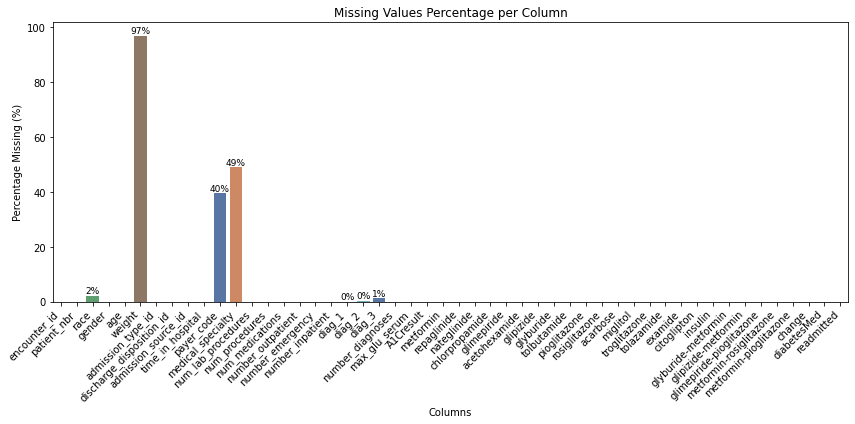

In [8]:
# checkin percentage of missing attribute per column
# Assuming 'df' is your DataFrame
missing_data = dt.isnull().mean() * 100  # Calculate the percentage of missing values per column

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_data.index, y=missing_data.values, palette='deep')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing (%)')
plt.title('Missing Values Percentage per Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate the bars with percentage values (if greater than 0)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.0f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',fontsize=9)
plt.show()

In [94]:
# Remove ID variables, Weight
dt=dt.drop(["patient_nbr","encounter_id","weight"],axis=1)

In [6]:
# Combining our targe to Yes and No instead of [No, >30, <30]
dup_data = dt.copy(deep=True)

# Update "readmitted" column
dup_data.loc[dup_data["readmitted"] == ">30", "readmitted"] = "YES"
dup_data.loc[dup_data["readmitted"] == "<30", "readmitted"] = "YES"

# Check unique values in "readmitted" column
print(dup_data["readmitted"].unique())

['NO' 'YES']


In [95]:
age_id = {'[0-10)':5, 
          '[10-20)':15, 
          '[20-30)':25, 
          '[30-40)':35, 
          '[40-50)':45, 
          '[50-60)':55,
          '[60-70)':65, 
          '[70-80)':75, 
          '[80-90)':85, 
          '[90-100)':95}
dt['age'] = dt.age.replace(age_id)

## Looking to see correlation plot 

+ Checking correlation plot to see if we can use a variable that is correlated with our target variable to check those with the missing columns

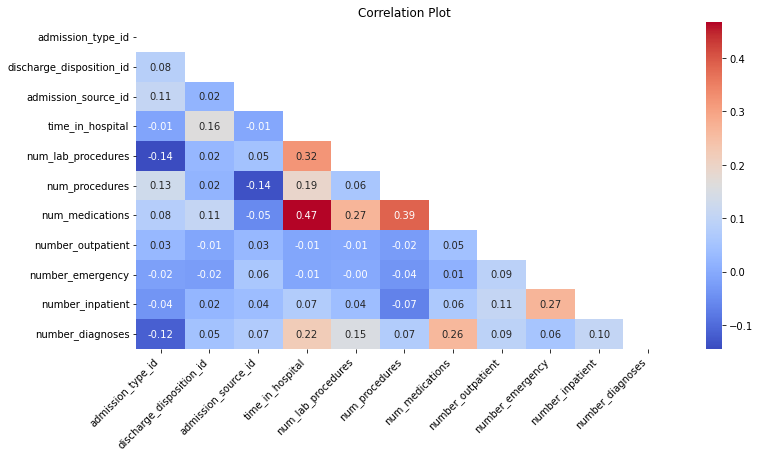

In [7]:
corr_matrix = dt.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 6))  

# Create the correlation plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

plt.xticks(rotation=45, ha='right')
plt.title('Correlation Plot')
plt.show()

**Relationships found per Corr plot**
+ Num of Medication and time in hospital
+ Lab procedures and time in hospital
+ Num procedures and num of medication
+ Num of diagnoses and num of medications
+ Num of diagnoses with time in hospital
+ Admission type  and num of procedures


# Using Semi-Supervise Algorithm to fill missing variables since relationships were found for the variables but there was not a third column that controlled it. They were missing completely at random

## >> Running a semi -supervised algorithm to imput medical_specialty since its missing completely at random

In [74]:
inputed_df=dt.copy(deep=True)

In [4]:
df = dt.copy()
unique_specialties=list(df["medical_specialty"].unique())

# Create a reference for the replaced medical specialty
specialty_to_number = {specialty: i for i, specialty in enumerate(unique_specialties)}

# Setting all missing variables with -1
specialty_to_number[np.nan]=-1

df['medical_specialty'] = df.medical_specialty.replace(specialty_to_number)

# creating a list with all categorical 
categorical_columns=list(df.select_dtypes(include=['object']).columns)

# One-hot encode categorical columns
data_encoded = pd.get_dummies(df, columns=categorical_columns)

In [6]:
import numpy as np
from sklearn import datasets
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# svc = SVC(probability=True, gamma="auto")
rf=RandomForestClassifier()
self_training_model = SelfTrainingClassifier(rf)
self_training_model.fit(data_encoded.drop('medical_specialty', axis=1), data_encoded['medical_specialty'])

SelfTrainingClassifier(base_estimator=RandomForestClassifier())

In [13]:
# Predict missing variable
predic_ms=self_training_model.predict(data_encoded.drop('medical_specialty', axis=1))
new_=[]
for k in predic_ms:
    new_.append(unique_specialties[k])
    
# Fill in NA
inputed_df['medical_specialty']=new_

# Medical_specialty is no longer has missing variables
inputed_df.isnull().sum().to_frame(name='counts').query('counts > 0')


In [59]:
inputed_df.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
weight,98569
payer_code,40256
diag_1,21
diag_2,358
diag_3,1423


## >> Running a semi-supervised algorithm to imput race since its missing completely at random

In [54]:
df = dt.copy()
unique_specialties=list(df["race"].unique())

# Create a reference for the replaced medical specialty
race_to_number = {specialty: i for i, specialty in enumerate(unique_specialties)}

# Setting all missing variables with -1
race_to_number[np.nan]=-1
df['race'] = df.race.replace(race_to_number)

# creating a list with all categorical 
categorical_columns=list(df.select_dtypes(include=['object']).columns)

# One-hot encode categorical columns
data_encoded = pd.get_dummies(df, columns=categorical_columns)

# svc = SVC(probability=True, gamma="auto")
rf=RandomForestClassifier()
self_training_model = SelfTrainingClassifier(rf)
self_training_model.fit(data_encoded.drop('race', axis=1), data_encoded['race'])

In [58]:
# Predict missing variable
predic_ms=self_training_model.predict(data_encoded.drop('race', axis=1))
new_=[unique_specialties[k] for k in predic_ms]
    
# Fill in NA
dt['race']=new_
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

# Predict missing variable
predic_ms=self_training_model.predict(data_encoded.drop('race', axis=1))
new_=[unique_specialties[k] for k in predic_ms]
    
# Fill in NA
inputed_df['race']=new_
# Medical_specialty is no longer has missing variables
inputed_df.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
weight,98569
payer_code,40256
diag_1,21
diag_2,358
diag_3,1423


## >> Running a semi -supervised algorithm to input payer_code since its missing completely at random

In [61]:
df = dt.copy()
unique_specialties=list(df["payer_code"].unique())

# Create a reference for the replaced medical specialty
payer_code_to_number = {specialty: i for i, specialty in enumerate(unique_specialties)}

# Setting all missing variables with -1
payer_code_to_number[np.nan]=-1
df['payer_code'] = df.payer_code.replace(payer_code_to_number)

# creating a list with all categorical 
categorical_columns=list(df.select_dtypes(include=['object']).columns)

# One-hot encode categorical columns
data_encoded = pd.get_dummies(df, columns=categorical_columns)

# svc = SVC(probability=True, gamma="auto")
rf=RandomForestClassifier()
self_training_model = SelfTrainingClassifier(rf)
self_training_model.fit(data_encoded.drop('payer_code', axis=1), data_encoded['payer_code'])

SelfTrainingClassifier(base_estimator=RandomForestClassifier())

In [67]:
# Predict missing variable
predic_ms=self_training_model.predict(data_encoded.drop('payer_code', axis=1))
new_=[unique_specialties[k] for k in predic_ms]
    
# Fill in NA
inputed_df['payer_code']=new_
# Medical_specialty is no longer has missing variables
# No missing variables
inputed_df.isnull().sum().to_frame(name='counts').query('counts > 0')


# Fixing diag_1, diag_2 and diag_3

+ Get the max of the three set as 1 and rest 0 so [250,na,5]->[1,0,0]


In [69]:
import warnings
warnings.filterwarnings("ignore")

diag_final = dt[['diag_1', 'diag_2', 'diag_3']]

# Convert the string values to numeric values (handling non-numeric strings)
numeric_dt = diag_final.apply(lambda col: pd.to_numeric(col, errors='coerce'))

# Find the locations of the maximum values in the numeric DataFrame
max_locations = (numeric_dt == numeric_dt.max(axis=1, skipna=True)[:, np.newaxis]).astype(int)


# Display the result
print(max_locations.head())


   diag_1  diag_2  diag_3
0       1       0       0
1       1       0       0
2       1       0       0
3       0       0       1
4       0       0       1


In [103]:
# imputing diagnosis values on both inputed_df and original df
dt['diag_1']=max_locations['diag_1']
inputed_df['diag_1']=max_locations['diag_1']

dt['diag_2']=max_locations['diag_2']
inputed_df['diag_2']=max_locations['diag_2']

dt['diag_3']=max_locations['diag_3']
inputed_df['diag_3']=max_locations['diag_3']

In [71]:
# Diag columns no longer have missing variables
# --> No missing variables!!!!!
inputed_df.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts


# Earlier attempts at imputting [race, and payer_code]missing variables by finding patterns after looking throught the raw data

## >> Inputing Race
***Race Patterns***
+ Across all numeric variables caucasians have the lowest variance followed by African Americans then by hispanics,  others and Asians

Diagnoses
+ Caucasians have the ***highest mean*** of diagnoses of 7.53  with very low variability
+ Hispanics have the ***lowest mean*** 6.9 with a range going as low as 6.8 and high as 7
+ African Americans stick to 7.1 mean with low variability
+ Asians have the highest variability from 6.9 to 7.2 at a mean with 7
+ Other have almost a mean of 7.3 with some variabiity
Impatient 
+ Cacasians again have the lowest variability but sit at .64m mean second highest inpatient
+ The highest is African americans with .7

+ Number_impation  is 1 median for ***minorities*** on the group <30, African American, Asian and hispanic
+ Hispanics have 0 number of procedures for >30 and NO. Asisn <30 have a median procedure of 0
+ Race vs the rest of the continuous variables seems to not be all around the same median range
+ The group that gets readmitted the lowest is Asians 35% while Caucasians are the highest readmission with 46% followed by Affrican Americans with 45%
+ Time in hospital, num_lab_procedure, num_medications seem to be the only ones correlated with the different races
+ Disposition_id and readmission [<30,>30,NO] seem to have a relationship


####  We can't combine >30 and <30 to yes there seems to be a pattern for each
+ Each race seems to have their pattern with some of the different numeric variables

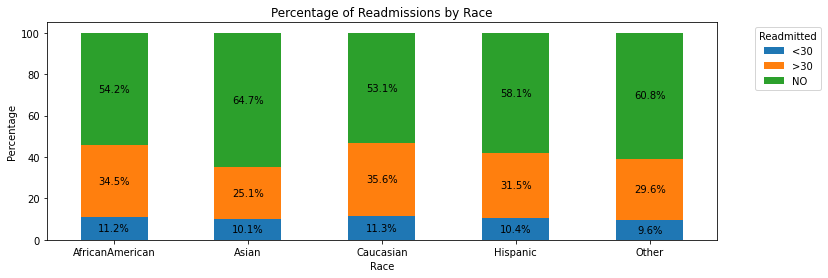

In [164]:
counts = dt.groupby(['race', 'readmitted']).size().unstack(fill_value=0)

# Calculate the percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
ax = percentages.plot(kind='bar', figsize=(12, 4), stacked=True)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')
    

plt.xlabel('Race')
plt.ylabel('Percentage')
plt.title('Percentage of Readmissions by Race')

plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Show the plot
plt.show()

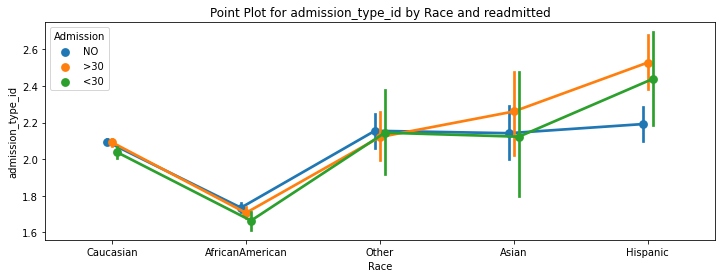

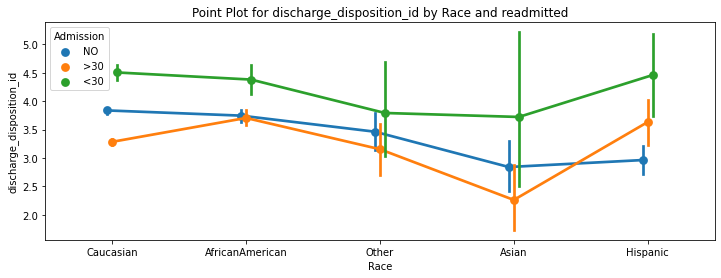

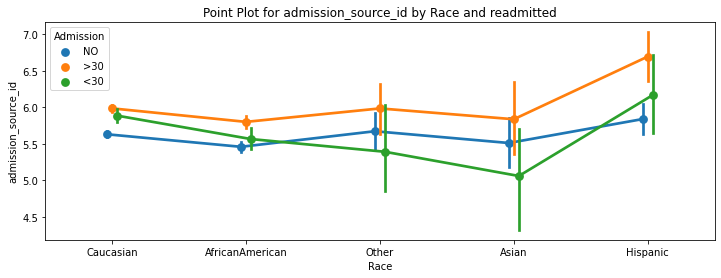

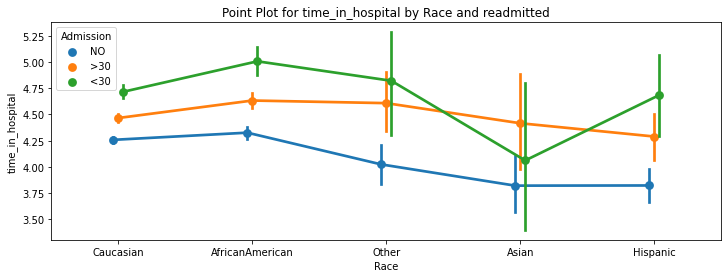

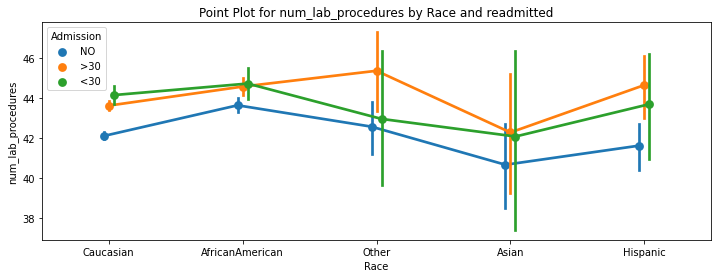

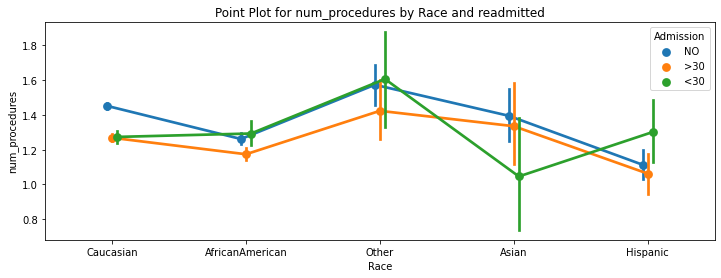

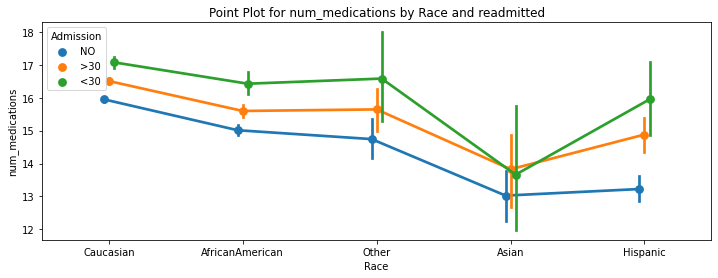

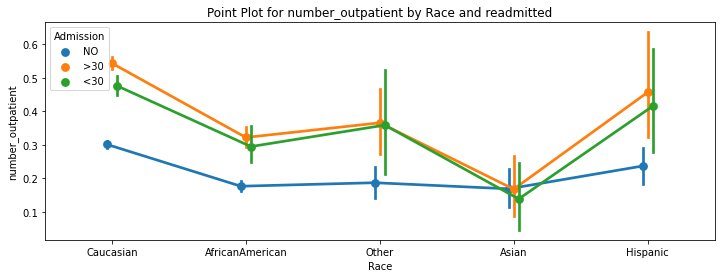

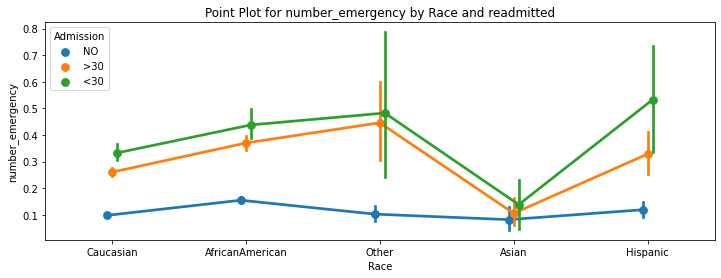

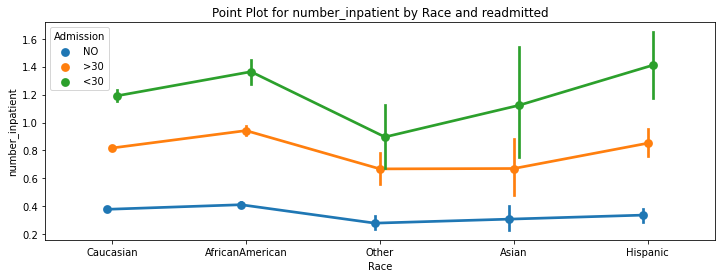

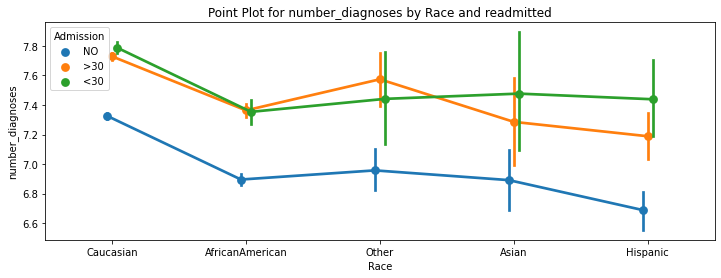

In [28]:
cont_df=dt.select_dtypes(exclude=['object'])
# Continues variable by race and readmission 
for i in cont_df.columns:
    plt.figure(figsize=(12, 3))  
    sns.pointplot(x='race', y=i, data=dt, hue='readmitted', dodge=True)  
    plt.title(f'Point Plot for {i} by Race and readmitted')  
    plt.xlabel('Race')  
    plt.ylabel(i)  
    plt.legend(title='Admission')  
    plt.show()  
    
    

+ Race has a relation with Time in hospital, num_lab_procedure, num_medications but chose mode Num_medication to impute missing variables since that has the highest variability

In [83]:
from scipy.stats import chi2_contingency
import scipy
chisqt = pd.crosstab(dt.race, dt.num_medications, margins=True)

value = np.array([chisqt.iloc[0][0:75].values,
                  chisqt.iloc[1][0:75].values,
                  chisqt.iloc[2][0:75].values,
                  chisqt.iloc[3][0:75].values,
                  chisqt.iloc[4][0:75].values
                 ])

chi2_stat, p_val, dof, expected = chi2_contingency(value)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)


Chi-squared statistic: 798.3545946213115
P-value: 9.375516725969002e-48
Degrees of freedom: 296


In [96]:
race_by_numimp = dt.groupby(['readmitted', 'num_medications'])['race'].apply(lambda x: x.mode().iloc[0])

# Replace NA in "race" using race_by_numimp
for i in range(len(dt)):
    if pd.isna(dt.at[i, 'race']):
        readmitted_value = dt.at[i, 'readmitted'] 
        num_medications_value = dt.at[i, 'num_medications']
        if (readmitted_value, num_medications_value) in race_by_numimp.index:
            imputed_race = race_by_numimp.loc[(readmitted_value, num_medications_value)]
            dt.at[i, 'race'] = imputed_race

In [97]:
dt["race"].isna().mean()
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
payer_code,40256
medical_specialty,49949
diag_1,21
diag_2,358
diag_3,1423


+ There is enough evidence to reject the null hypothesis of all races having equal number of medication (p_val=9.375516725969002e-48). We observed this relationship as well in the plots which why we are using this variable to impute missing valus in Race

## >> payer_code imputation


In [36]:
dt['payer_code'].unique()

array([nan, 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [55]:
dt.groupby('payer_code')['race'].value_counts(normalize=True).mul(100).round(1)

payer_code  race           
BC          Caucasian          77.7
            AfricanAmerican    19.0
            Hispanic            1.8
            Other               1.0
            Asian               0.6
                               ... 
UN          Other               1.9
            Asian               1.8
WC          Caucasian          77.0
            AfricanAmerican    17.8
            Hispanic            5.2
Name: race, Length: 73, dtype: float64

+ The users of OT have over 50% African americans

+ Looked at the raw data in excel and didn't find any pattens but though Age, Race and Insulin would have an influence as well as age vs Payer_code.
+ Therefore we plotted to see if there was any realationship between Payer code, age and race as well as age vs Payer_code but no emminent relationship found to help impute data.  

+ the median of age for all the races in the data with the missing payer_code is 65 year old.

***ultimatly no pattern was found thus will will replace missing variables for payer code with unique flag***

In [140]:
dt[dt["payer_code"].isna()].groupby("race").median()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
race,,,,,,,,,,,,
AfricanAmerican,65.0,1.0,1.0,7.0,4.0,45.0,1.0,13.0,0.0,0.0,0.0,7.0
Asian,65.0,2.0,1.0,7.0,3.0,42.0,1.0,11.0,0.0,0.0,0.0,7.0
Caucasian,65.0,2.0,1.0,7.0,4.0,45.0,1.0,15.0,0.0,0.0,0.0,8.0
Hispanic,65.0,1.0,1.0,7.0,3.0,45.0,0.0,13.0,0.0,0.0,0.0,6.0
Other,65.0,2.0,1.0,7.0,4.0,45.0,1.0,14.0,0.0,0.0,0.0,7.0


FR is an outlier so we can't use it to impute Payer_code
+ times in hospital =10 then Payer code is FR
+ num_lab_procedures >60  then Payer code is FR
+ num_medications  ==39 then Payer FR

+ A lot of African american look at their insuling have 34% as steady while the other races are 24-29%

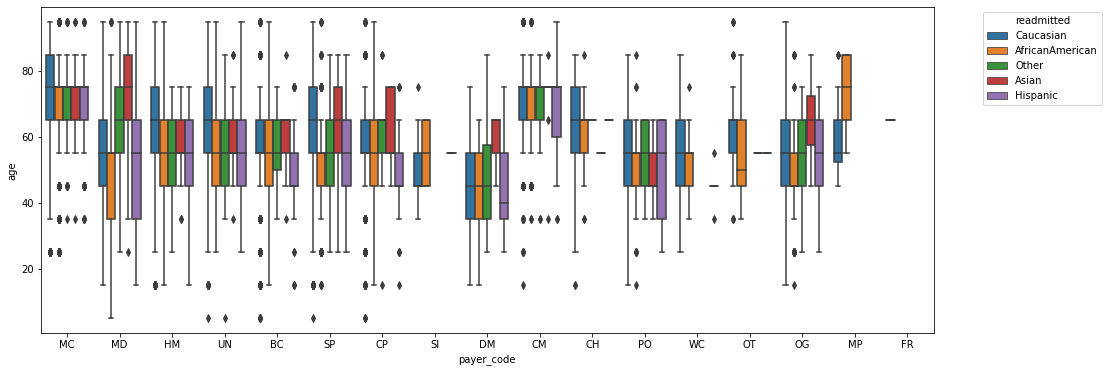

In [131]:
# sns.barplot(x="race", data= dt, hue="race")
# Create a strip plot
plt.figure(figsize=(16, 6))

sns.boxplot(x="payer_code", y="age", hue='race', data=dt)
plt.legend(title='readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')



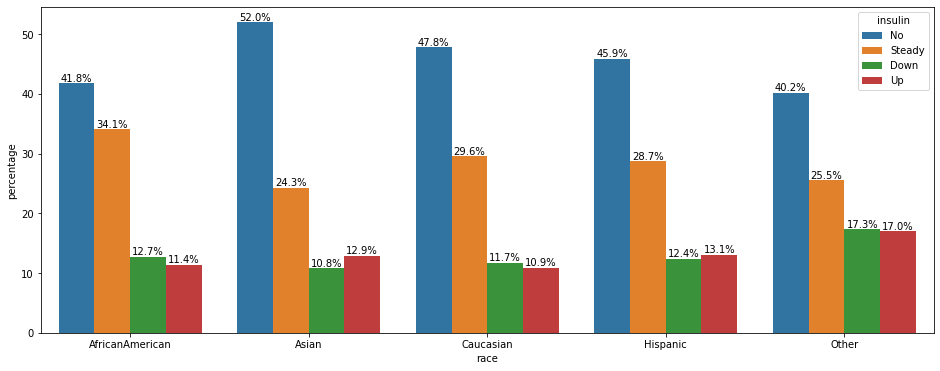

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

x, y, hue = "race", "percentage", "insulin"

# Create the bar plot
ax = sns.barplot(data=dt[hue]
        .groupby(dt[x])
        .value_counts(normalize=True)
        .mul(100)
        .round(1)
        .rename(y)
        .reset_index(), x=x, y=y, hue=hue)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


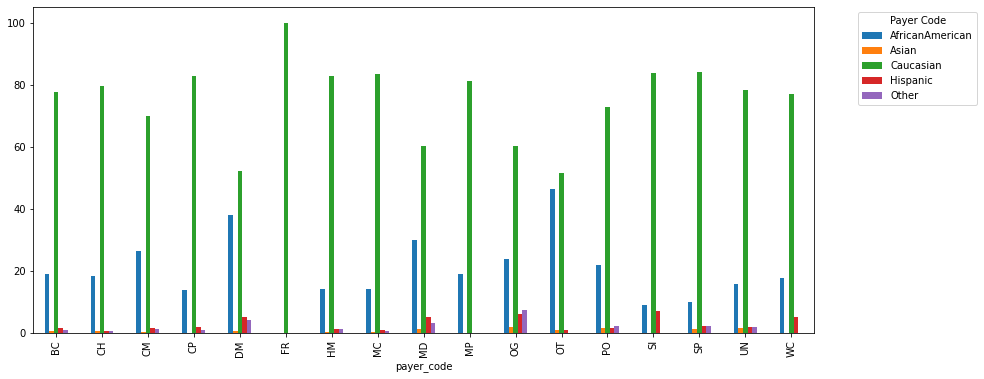

In [84]:
l=pd.crosstab( dt['payer_code'],dt['race'],normalize='index')*100
l.plot(kind='bar', figsize=(14, 6)).legend(title='Payer Code', bbox_to_anchor=(1.05, 1), loc='upper left')


In [98]:
dt['payer_code'].fillna('extra', inplace=True)

In [104]:
dt["race"].isna().mean()
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts


## >> Attempts at looking into medical_specialty to input values but we ended keeping the inputed values of the semi-supervised for this after looking at plots and running a random forest algor moved at the very end of the notebook since it only reached 50%  accuracy and 10% F1 score

In [16]:
readmit = pd.crosstab(dt['medical_specialty'], dt['readmitted'])

# Calculate the percentage based on the sum of counts within each race group
readmit_percentage = readmit.div(readmit.sum(1), axis=0) * 100

readmit_percentage.sort_values(by='NO', ascending=False).head(5)

readmitted,<30,>30,NO
medical_specialty,,,
Psychiatry-Addictive,0.0,0.0,100.0
Speech,0.0,0.0,100.0
Neurophysiology,0.0,0.0,100.0
Perinatology,0.0,0.0,100.0
Proctology,0.0,0.0,100.0


In [17]:
# Looking at num Medications and Readmitted relation with "medical specialty"
# info on the missing data on Medical Specialty in relation to readmitted and number of diagnoses
# the mean is 15
dt[dt['medical_specialty'].isnull()][["readmitted","num_medications"]].describe()

,num_medications
count,49949.000000
mean,16.326573
std,7.951627
min,1.000000
25%,11.000000
50%,15.000000
75%,20.000000
max,72.000000


In [26]:
# Lets create a crosstab and find those that have a median of 15
p=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["num_medications"], aggfunc='median')
# Filter those columns were at least one category equal to 15
p[(p == 15).any(axis=1)]


readmitted,<30,>30,NO
medical_specialty,,,
Cardiology,16.0,15.0,15.0
Family/GeneralPractice,15.0,14.0,12.0
Hospitalist,17.0,15.0,16.0
InternalMedicine,15.0,14.0,13.0
Oncology,14.0,16.0,15.0
Otolaryngology,12.0,19.0,15.0
Pediatrics-Pulmonology,12.0,15.0,14.0
Podiatry,22.5,16.0,15.0
Pulmonology,18.0,15.0,13.0


+ An option for the missing variables in medical_specialty would be
    - Yes "<30"=Could be(Family/GeneralPractice or InternalMedicine Surgeon)
    - Yes ">30"= Cardiology, Hospitalist, Pediatris-Pulmonology, Pulmonology or Surgery-PlasticWithinHeadandNeck
    - NO= Cardiology, Oncology, Otolaryngology, Podiatry, Surgeon or Surgery_general
+ However, we are aware there may not be a relationship 100% however better than guessing

In [75]:
#Diagnoses would have a relation with Medical specialty so looking into that relationship
#info on the missing data in relation to readmitted and number of diagnoses
dt[dt['medical_specialty'].isnull()][["readmitted","number_diagnoses"]].describe()

,number_diagnoses
count,49949.000000
mean,7.748764
std,1.785262
min,1.000000
25%,7.000000
50%,9.000000
75%,9.000000
max,16.000000


In [90]:
p=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["number_diagnoses"], aggfunc='median')
# Too many options and no pattern was found
len(p[(p == 9).any(axis=1)])

# p.sort_values(by='NO', ascending=False).head(10)

29

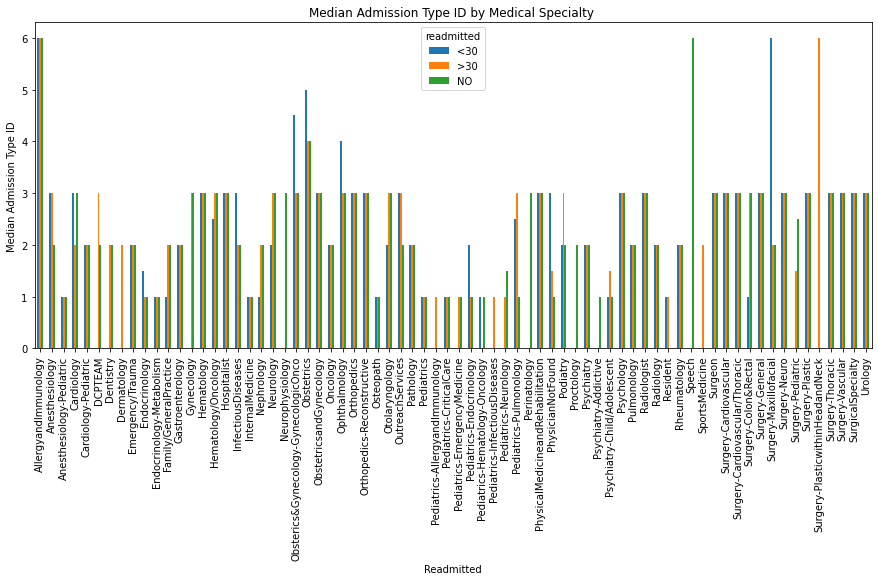

In [34]:
# Plot the transposed DataFrame
p.plot(kind='bar', figsize=(15, 6))  # You can adjust the figure size as needed

# Add labels and title
plt.xlabel('Readmitted')
plt.ylabel('num_medications')
plt.title('Median num_medications by Medical Specialty ')

plt.show()

l=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["admission_type_id"], aggfunc='median')

# Plot the transposed DataFrame
l.plot(kind='bar', figsize=(15, 6))  # You can adjust the figure size as needed

# Add labels and title
plt.xlabel('Readmitted')
plt.ylabel('Median Admission Type ID')
plt.title('Median Admission Type ID by Medical Specialty ')

plt.show()

# EDA
## Looking at the categorical variables

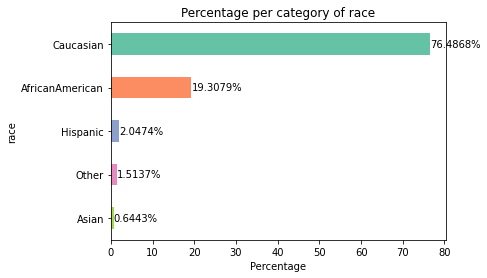

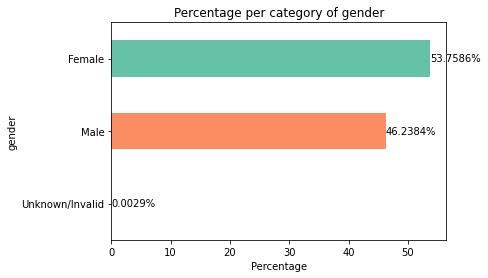

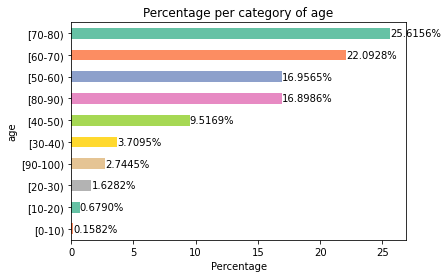

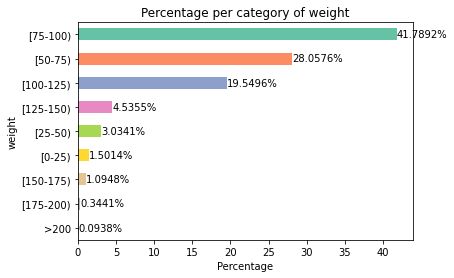

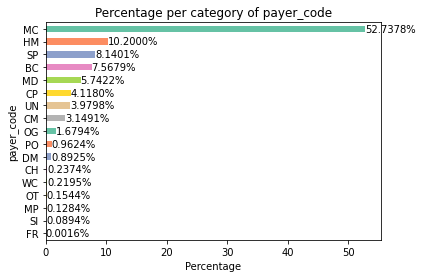

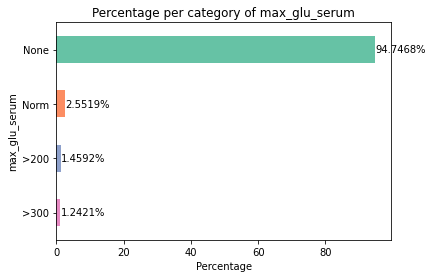

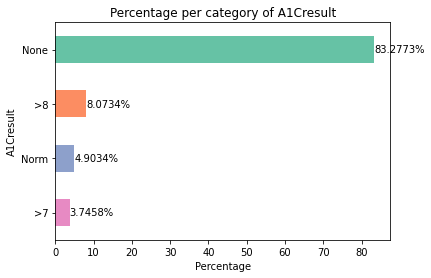

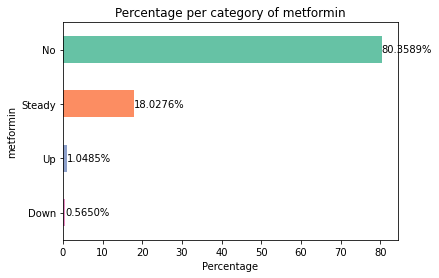

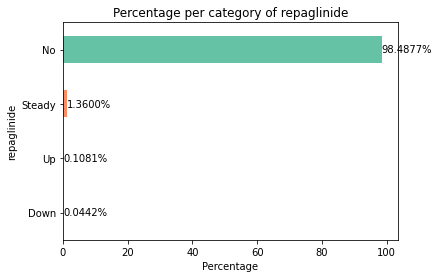

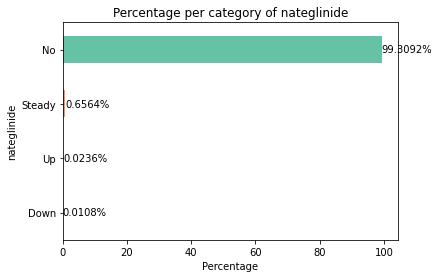

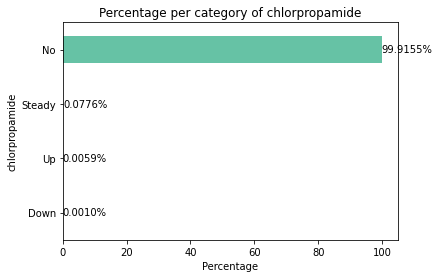

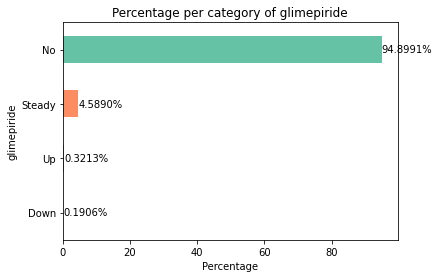

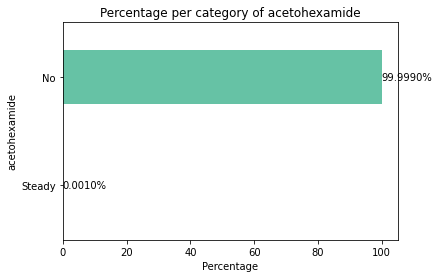

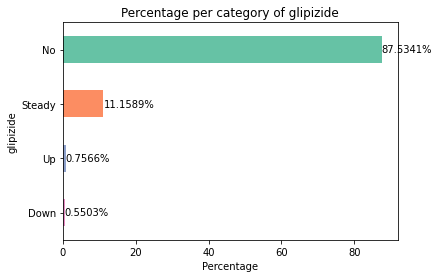

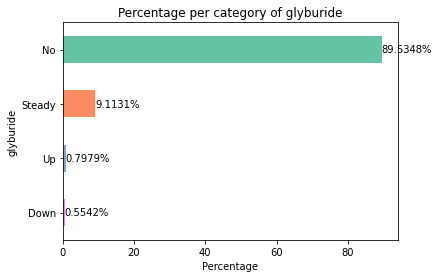

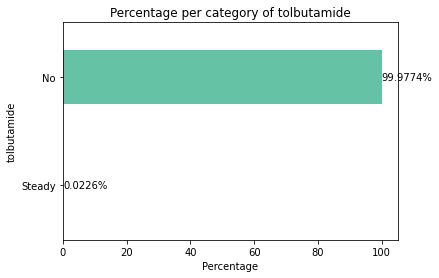

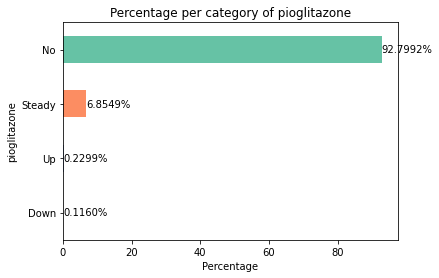

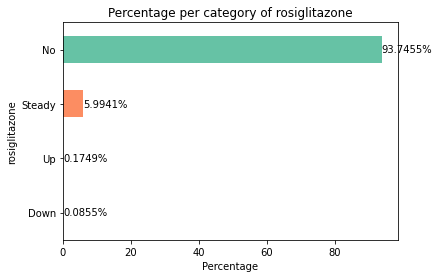

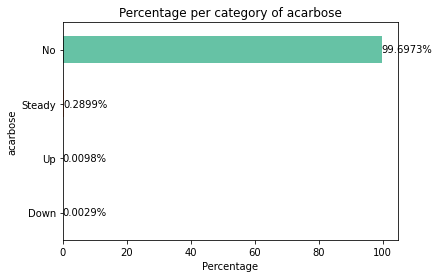

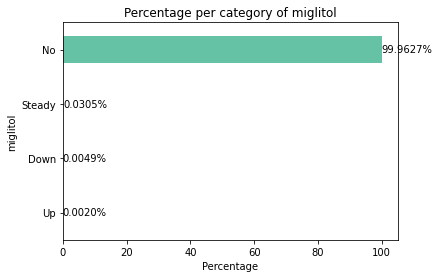

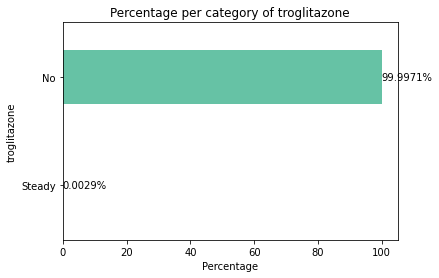

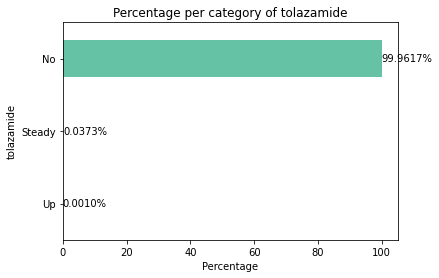

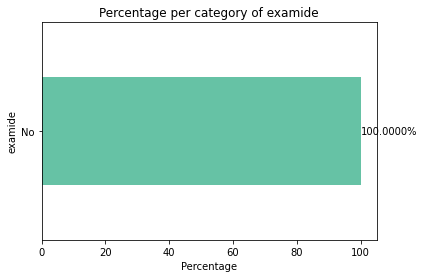

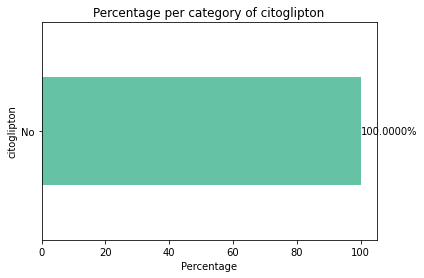

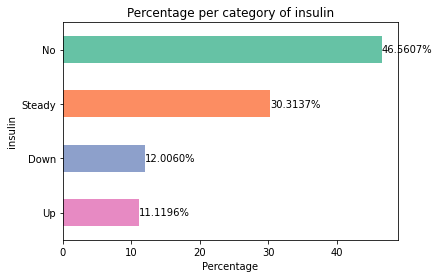

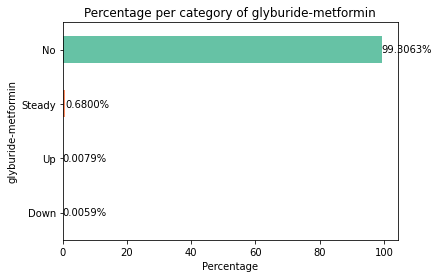

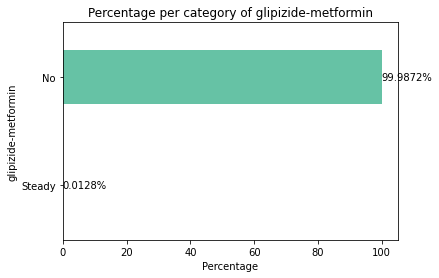

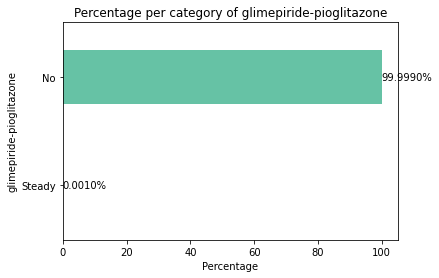

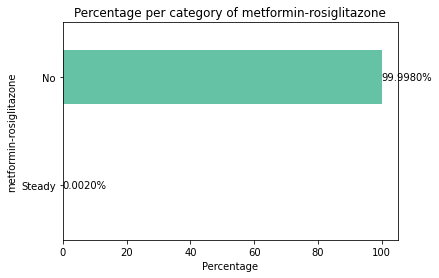

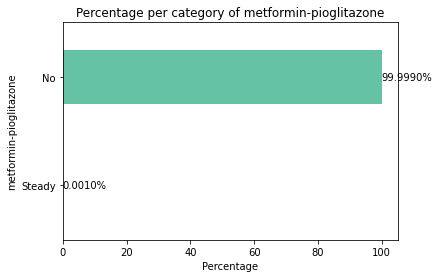

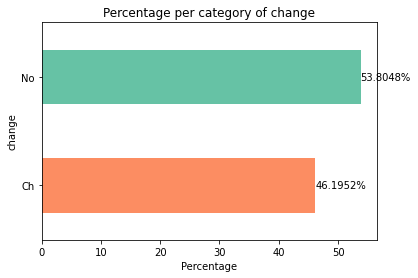

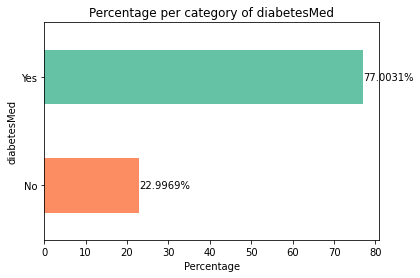

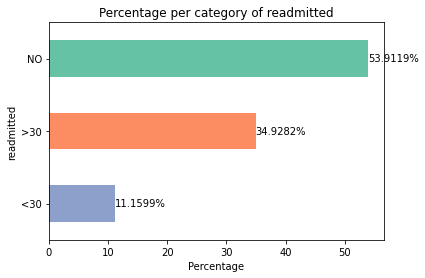

In [62]:
#Assuming 'data' is your DataFrame
cat_df = dt.select_dtypes(include=['object']).drop(["medical_specialty", "diag_1", "diag_2", "diag_3""diag_1", "diag_2", "diag_3"], axis=1)

# Get the number of unique categories for each column
num_categories = cat_df.nunique()

# Define a color palette with as many colors as there are unique categories
color_palette = sns.color_palette("Set2", n_colors=num_categories.max())

for i in cat_df.columns:
    value_counts = dt[i].value_counts(normalize=True)
    colors = color_palette[:len(value_counts)]
    
    ax = value_counts.mul(100).plot(kind="barh", color=colors)
    
    plt.xlabel("Percentage")
    plt.ylabel(i)
    plt.title(f"Percentage per category of {i}")
    plt.gca().invert_yaxis()
    
    for index, value in enumerate(value_counts.mul(100)):
        ax.text(value, index, f'{value:.4f}%', ha='left', va='center', color='black')

    plt.show()
    
# Diabetes, change, metformin-piogitazone but flit no=yes could be turned into numeric


+ 76% is Caucasian
+ Age bucket is larger and ther is a correlation the older get hospitilized more 
+ Drop citoglipton and examide since the only value is "No"

In [138]:
# Droping examide and citoglipton which only had 1 as the value
dt=dt.drop(dt[['examide','citoglipton']], axis=1)

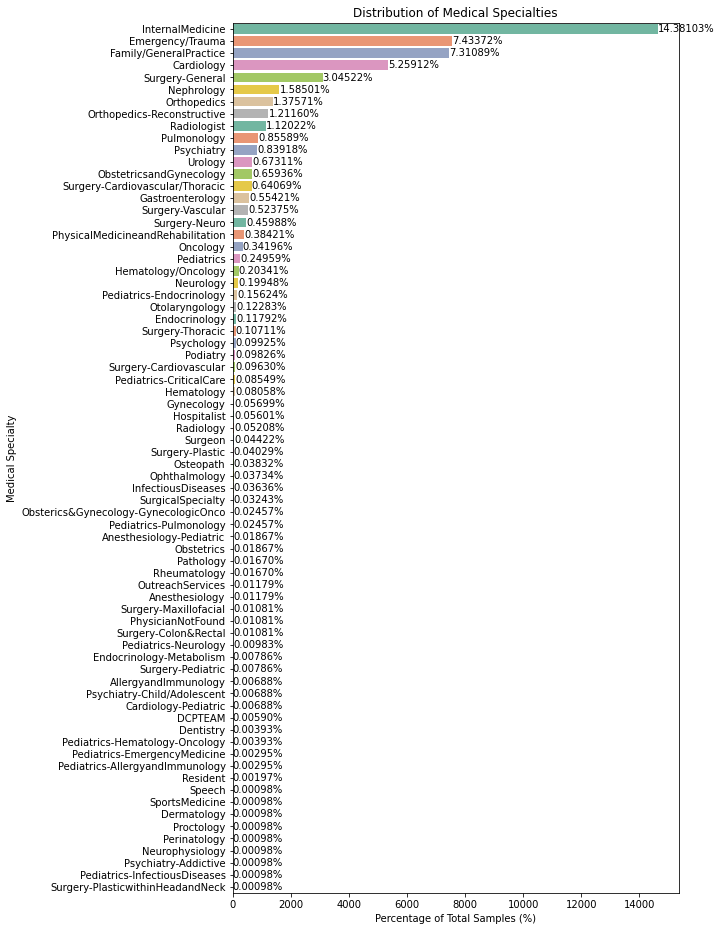

In [108]:
# Create a countplot of medical specialty percentages since it coudln't be printed above due to size
plt.figure(figsize=(8, 16))
sns.countplot(
    y=dt['medical_specialty'],
    orient='h',
    palette='Set2',
    order=dt['medical_specialty'].value_counts().index,  # Sort by count
)
plt.xlabel('Percentage of Total Samples (%)')
plt.ylabel('Medical Specialty')
plt.title('Distribution of Medical Specialties')

# Annotate the bars with percentage values
for p in plt.gca().patches:
    width = p.get_width()
    percentage = (width / len(dt)) * 100
    plt.gca().annotate(f'{percentage:.5f}%', (width + 1, p.get_y() + p.get_height() / 2), ha='left', va='center')

plt.show()


1: max diag ==1 rest 0 -->1,0,0
2: all ? to 0

## Looking a numeric variables
+ comments
+ admission_type_id -> Difference between 5 Not Available, 8 Not Mapped, 6 NULL
+ discharge_disposition_id -> 18 NULL, 25 Not Mapped, 26 Unknown/Invalid
+ admission_source_id-->9 NOT AVAILable, 15 NOT AVAILable ,17 NULL
+ Interesting num of medication is normaly distributed

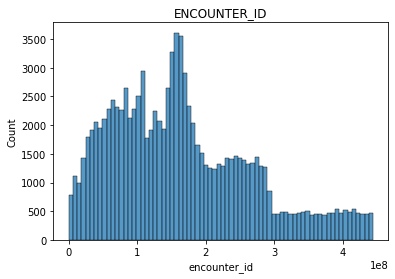

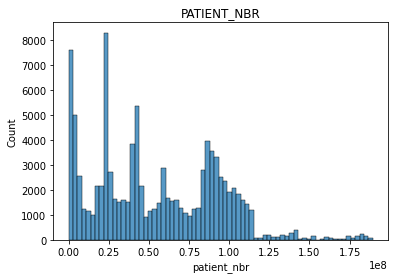

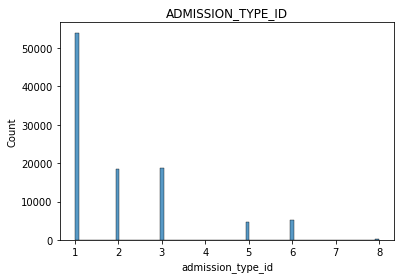

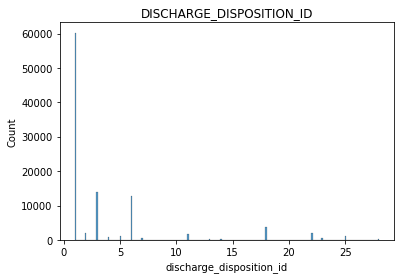

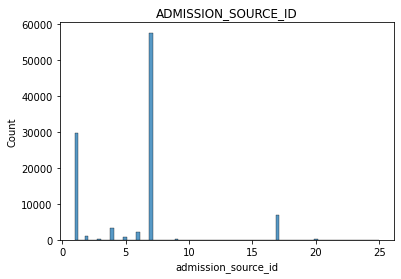

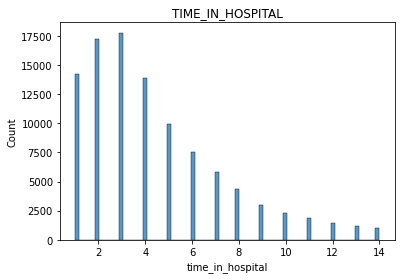

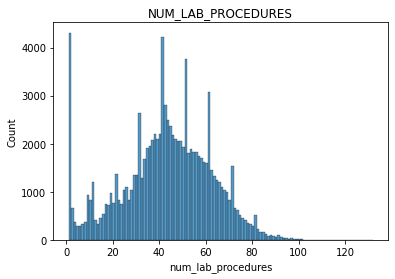

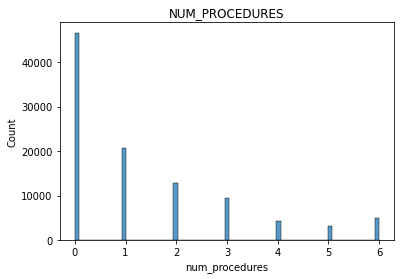

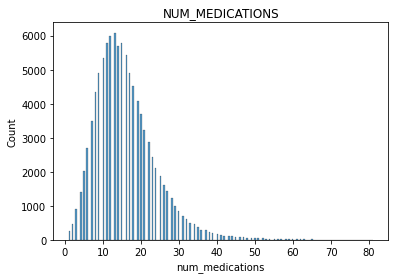

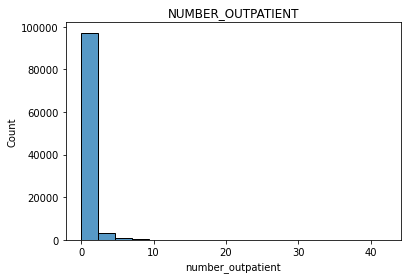

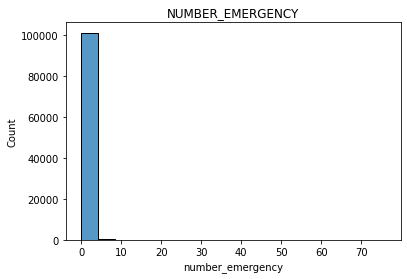

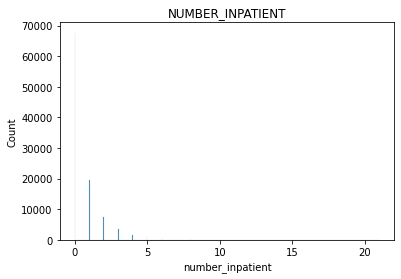

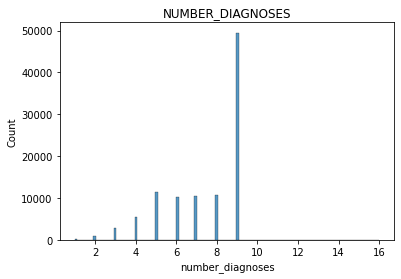

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in data.select_dtypes(include=['int64']).columns:
    sns.histplot(data[i],kde=False)
    plt.title(i.upper())
    plt.show()


***EDA completed***

# Run Model 

In [76]:
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts


In [77]:
dt.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

+ One hot encoding categorical variables

In [109]:
# creating a list with all categorical 
categorical_columns=list(dt.select_dtypes(include=['object']).columns)
categorical_columns.remove('readmitted')

# One-hot encode categorical columns

# With the inputed values from the semi supervise alg
model_dt = pd.get_dummies(inputed_df, columns=categorical_columns)
# With the imputed manual updates
# --> Medical_specialty with semi supervise, race using num_medication as reference and payer code with using a flag variable
model_dt_ManualUpdate=pd.get_dummies(dt, columns=categorical_columns)


In [117]:


# Split the data into features and target
X = model_dt.drop("readmitted",axis=1)
y = model_dt['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

class_report = classification_report(y_test, y_pred)


print(f'Classification Report:\n{class_report}')


Classification Report:
              precision    recall  f1-score   support

         <30       0.36      0.01      0.02      2285
         >30       0.49      0.26      0.34      7117
          NO       0.59      0.89      0.71     10952

    accuracy                           0.57     20354
   macro avg       0.48      0.39      0.36     20354
weighted avg       0.53      0.57      0.50     20354



In [87]:
from sklearn.model_selection import cross_val_score
cross_lr = LogisticRegression()

# Perform k-fold cross-validation (e.g., 5-fold)
num_folds = 5
cross_val_scores = cross_val_score(cross_lr, X, y, cv=num_folds, scoring='accuracy')
print("Cross-validated Accuracy Scores:")
print(cross_val_scores)

# Calculate and print the mean accuracy score
mean_accuracy = cross_val_scores.mean()
print(f"Mean Accuracy: {mean_accuracy:.2f}")


Cross-validated Accuracy Scores:
[0.55846517 0.56473247 0.55721515 0.57903012 0.58099543]
Mean Accuracy: 0.57


In [88]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear')
model_l2 = LogisticRegression(penalty='l2')


num_folds = 5
cross_val_scores_l1 = cross_val_score(model_l1, X, y, cv=num_folds, scoring='accuracy')
cross_val_scores_l2 = cross_val_score(model_l2, X, y, cv=num_folds, scoring='accuracy')

print("Cross-validated Accuracy Scores for L1 Regularization (Lasso):")
print(cross_val_scores_l1)
print("\nCross-validated Accuracy Scores for L2 Regularization (Ridge):")
print(cross_val_scores_l2)

print(f"Mean Accuracy for L1 Regularization (Lasso): {cross_val_scores_l1.mean():.2f}")
print(f"Mean Accuracy for L2 Regularization (Ridge): {cross_val_scores_l2.mean():.2f}")

Cross-validated Accuracy Scores for L1 Regularization (Lasso):
[0.55772821 0.56286543 0.55814868 0.5749521  0.58124109]

Cross-validated Accuracy Scores for L2 Regularization (Ridge):
[0.55846517 0.56473247 0.55721515 0.57903012 0.58099543]
Mean Accuracy for L1 Regularization (Lasso): 0.57
Mean Accuracy for L2 Regularization (Ridge): 0.57


In [141]:
# Using Manual update df
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X_mu = model_dt_ManualUpdate.drop("readmitted",axis=1)
y_mu = model_dt_ManualUpdate['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X_mu, y_mu, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

class_report = classification_report(y_test, y_pred)


print(f'Classification Report:\n{class_report}')


Classification Report:
              precision    recall  f1-score   support

         <30       0.37      0.01      0.02      2285
         >30       0.50      0.26      0.34      7117
          NO       0.59      0.89      0.71     10952

    accuracy                           0.57     20354
   macro avg       0.48      0.39      0.36     20354
weighted avg       0.53      0.57      0.50     20354



+ remember ---> talk about using gender,race and age in data at the end

# Extra
# ----->  That was not used

## Running Random Forest to replacing missing medical_specialty values

In [70]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

# # creating a list with all categorical varible excluding Medical specialty
# categorical_columns=list(dt.select_dtypes(include=['object']).columns)
# categorical_columns.remove("medical_specialty")

# # One-hot encode categorical columns
# data_encoded = pd.get_dummies(dt, columns=categorical_columns)

# #saving the hot encoded features with missing medical specialty for later
# unlabeled_X=data_encoded[data_encoded["medical_specialty"].isnull()].drop("medical_specialty",axis=1)
# print(unlabeled_X.shape," Missing variables medical_specialty")

# # Removing all the rows with Medical Specialty missing
# data_encoded=data_encoded.dropna(subset=["medical_specialty"])
# print(data_encoded.shape, " without Missing variables medical_specialty")

# X_=data_encoded.drop("medical_specialty", axis=1)
# y_=data_encoded["medical_specialty"]

# X_train,X_test, Y_train, Y_test=train_test_split(X_,y_, test_size=0.2, random_state=42)
# rm=RandomForestClassifier()

# rm.fit(X_train, Y_train)

# pr=rm.predict(X_test)

# print('Accuracy:',accuracy_score(Y_test, pr))

(49949, 2394)  Missing variables medical_specialty
(51817, 2395)  without Missing variables medical_specialty


In [89]:
# # Having built the model predict on the actual missing data
# missing_MS=rm.predict(unlabeled_X)
# missing_MS=list(missing_MS)

# # Replaced nul values with predicted values from Randm forest
# dt["medical_specialty"]=dt.apply(lambda row: missing_MS.pop(0) if pd.isna(row["medical_specialty"]) else row["medical_specialty"], axis=1)
# dt["medical_specialty"].isnull().mean() 

0.0

In [38]:
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
race,2273
weight,98569
payer_code,40256
diag_1,21
diag_2,358
diag_3,1423
